In [1]:
!nvidia-smi

Tue Dec 29 02:20:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget -O data.zip https://husteduvn-my.sharepoint.com/:u:/g/personal/thanh_lt163705_sis_hust_edu_vn/EfZ-d1e94lJIu95YakpVO8gBBtQ5r77m16bNkzcI0lUI_g?download=1
!unzip data.zip

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install fastai --upgrade

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
import torch.nn as nn
from fastai.text.all import (
    L, params, Path, partial, pad_input,
    tensor, TitledStr, TensorCategory, Category,
    Transform, AttrGetter, Pipeline, ItemGetter,
    Datasets,
    Categorize, CategoryMap,
    RandomSplitter,
    Learner,
    accuracy, F1Score, Recall,
    Adam, LabelSmoothingCrossEntropy,
    ShowGraphCallback, Callback, Metric,
)
from transformers import (
    PhobertTokenizer, RobertaModel, RobertaConfig,
    AutoModel, AutoConfig, AutoTokenizer,
)
import random
import numpy as np
import re
from typing import *
from collections import defaultdict
import logging
from torchcrf import CRF
from conlleval import evaluate
import warnings
warnings.filterwarnings("ignore")

# Config logging

In [8]:
!mkdir log

In [9]:
logging.basicConfig(
    level=logging.DEBUG,
    filename='log/bert_ner.log',
    filemode='a',
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%d-%b-%y %H:%M:%S',
)


# Utils

## Seed all

In [10]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [11]:
seed_all(42)

## Config class

In [12]:
class Config:
    def __init__(self, *args, **kwargs):
        for k, v in kwargs.items():
            self.__setattr__(k, v)

# Load data

## Read data from text file

In [13]:
def read_data(fn: Union[str, Path]):
    with open(fn, mode='r', encoding='utf8') as f:
        txt = f.read()

    results = L()
    sentences = re.split(r'\n\n', txt)
    for sentence in sentences:
        lines = sentence.split('\n')
        words, pos, chunk, labels = zip(*[re.split('\t', line.strip()) for line in lines])

        words = L(re.sub(r' ', '_', w) for w in words)
        labels = list(labels)

        results.append((words, L(pos), L(chunk), L(labels)))

    return results

### Test read data

In [ ]:
# test_data = read_data('data/raw/test.txt')
# test_data[0]

((#28) ['Chị','Minh','ôm','đứa','con_gái','mới','hơn','hai','tháng','rưỡi'...],
 (#28) ['Nc','Np','V','Nc','N','R','A','M','N','M'...],
 (#28) ['B-NP','B-NP','B-VP','B-NP','B-NP','O','B-AP','B-NP','B-NP','B-NP'...],
 (#28) ['O','B-PER','O','O','O','O','O','O','O','O'...])

## Process data

### Words transform

In [14]:
class WordTransform(Transform):
    def __init__(self, tokenizer: PhobertTokenizer):
        super(WordTransform, self).__init__()
        self.tokenizer = tokenizer
        self._i2pos, self._i2chunk = None, None
        self._pos2i, self._chunk2i = defaultdict(int), defaultdict(int)

    def setups(self, items):
        all_pos, all_chunk = [], []
        for item in items:
            all_pos.extend(list(item[0][1]))
            all_chunk.extend(list(item[0][2]))

        pos = sorted(list(set(all_pos)))
        chunk = sorted(list(set(all_chunk)))

        self._i2pos, self._i2chunk = pos, chunk
        self._pos2i = {p: i for i, p in enumerate(pos)}
        self._chunk2i = {c: i for i, c in enumerate(chunk)}

    def encodes(self, x):
        words, pos, chunk = x

        # process word
        tokens = []
        len_words = []
        for word in words:
            w_tokens = self.tokenizer.tokenize(word)
            tokens.append(w_tokens)
            len_words.append(len(w_tokens))

        n_words = len(np.where(np.cumsum(len_words) <= (self.tokenizer.max_len_single_sentence - 2))[0])

        tokens = [self.tokenizer.cls_token, *(sum(tokens[:n_words], [])), self.tokenizer.sep_token]
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

        # process pos and chunk
        pos = [self._pos2i[p] for p in pos[:n_words]]
        chunk = [self._chunk2i[c] for c in chunk[:n_words]]
        return {
            'token_ids': token_ids,
            'n_words': n_words,
            'len_words': tensor(len_words),
            'pos': tensor(pos),
            'chunk': tensor(chunk),
        }

    def decodes(self, x):
        token_ids = x['token_ids']
        return TitledStr(self.tokenizer.decode(token_ids))

In [15]:
class WordTransformV2(Transform):
    def __init__(self, tokenizer: PhobertTokenizer):
        super(WordTransformV2, self).__init__()
        self.tokenizer = tokenizer

    def encodes(self, x):
        words = x

        # process word
        tokens = []
        len_words = []
        for word in words:
            w_tokens = self.tokenizer.tokenize(word)
            tokens.append(w_tokens)
            len_words.append(len(w_tokens))

        n_words = len(np.where(np.cumsum(len_words) <= (self.tokenizer.max_len_single_sentence - 2))[0])

        tokens = [self.tokenizer.cls_token, *(sum(tokens[:n_words], [])), self.tokenizer.sep_token]
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

        return {
            'token_ids': torch.tensor(token_ids, dtype=torch.long),
            'n_words': n_words,
            'len_words': tensor(len_words),
        }

    def decodes(self, x):
        token_ids = x['token_ids']
        return TitledStr(self.tokenizer.decode(token_ids))

#### Test words transform

In [ ]:
test_data = read_data('data/raw/test.txt')
train_data = read_data('data/raw/train.txt')
test_data[0][0]

(#28) ['Chị','Minh','ôm','đứa','con_gái','mới','hơn','hai','tháng','rưỡi'...]

In [ ]:
tokenizer = PhobertTokenizer.from_pretrained('vinai/phobert-base')
tfms = Pipeline([WordTransformV2(tokenizer=tokenizer)])
tfms(test_data[0][0])

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


{'len_words': tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]),
 'n_words': 28,
 'token_ids': tensor([    0,  1108,  1612,  1896,   802,  9443,   238,    60,    48,    82,
            78,  7164,   126, 13098,    72,   150,   355, 29618,    26,   337,
            44,    13,   283,   523,    28,   224,   366,     7,   327,     5,
             2])}

### Categorize List

In [16]:
class CategorizeList(Categorize):
    def __init__(self, vocab=None, add_na=False, pad='[pad]'):
        super(CategorizeList, self).__init__(vocab=vocab, add_na=add_na)
        self.pad = pad

    @property
    def pad_idx(self):
        return self.vocab.o2i[self.pad]

    def setups(self, dsets):
        dsets = sum(dsets, L())
        dsets.append(self.pad)
        super(CategorizeList, self).setups(dsets=dsets)

    def encodes(self, os):
        return TensorCategory([self.vocab.o2i[o] for o in os])

    def decodes(self, os):
        return Category(' '.join([self.vocab[o] for o in os]))

### Before batch transform

In [17]:
class BeforeBatch(Transform):
    """
    - First: alignment pos, chunk, labels with number of used words
        -> (#6) (token_ids, pos, chunk, n_words, len_words, labels) (is aligned)
    - Second: Pad token_ids, pos, chunk, len_words (pad=0), labels
        => (#6) (token_ids, pos, chunk, n_words, len_words, labels) (is padded)
    """
    def __init__(self, pad_idxs: list, pad_fields: list, pad_firsts: list, use_pos_chunk=True):
        assert len(pad_idxs) == len(pad_firsts) == len(pad_fields), f'not {len(pad_idxs)} == {len(pad_firsts)} == {len(pad_fields)}'
        super(BeforeBatch, self).__init__()
        self._pad_funcs = [
            partial(pad_input, pad_idx=pad_idx, pad_fields=pad_field, pad_first=pad_first)
            for pad_idx, pad_field, pad_first in zip(pad_idxs, pad_fields, pad_firsts)
        ]
        self._pad_funcs.append(partial(
            pad_input, pad_idx=0, pad_fields=4 if use_pos_chunk else 2, pad_first=False,
        ))
        self._use_pos_chunk = use_pos_chunk

    def encodes(self, items):
        items = self.align(items, use_pos_chunk=self._use_pos_chunk)
        for pad_func in self._pad_funcs:
            items = pad_func(items)
            
        return items

    @staticmethod
    def align(items, use_pos_chunk):
        new_items = L()
        for w, *pos_chunk, labels in items:
            token_ids = w['token_ids']
            n_words = w['n_words']
            len_words = w['len_words']
            
            if use_pos_chunk:
                pos, chunk = pos_chunk
                pos = pos[:n_words]
                chunk = chunk[:n_words]
                pos_chunk = [pos, chunk]

            labels = labels[:n_words]
            new_items.append((torch.tensor(token_ids, dtype=torch.long), *pos_chunk, n_words, len_words, labels))
        return new_items


### Test create dataloader

#### Create datasets

In [ ]:
w_tfms = [ItemGetter(0), WordTransformV2(tokenizer)]
pos_tfms = [ItemGetter(1), CategorizeList(pad='[pad_p]')]
chunk_tfms = [ItemGetter(2), CategorizeList(pad='[pad_c]')]
y_tfms = [ItemGetter(3), CategorizeList(pad='[pad_l]')]
ds = Datasets(
    train_data,
    tfms=[w_tfms, pos_tfms, chunk_tfms, y_tfms],
)

In [ ]:
ds.show(ds[0])

<s> Đó là con đường biển ngắn nhất để đi từ Ấn_Độ_Dương sang Thái_Bình_Dương, chiếm đến lượng hàng_hoá lưu_thông đường_biển của thế_giới, đó là hải_trình lớn nhất từ tây sang đông với 50.000 lượt tàu_bè qua_lại mỗi năm... </s>
P V Nc N N A A E V E Np V Np CH V E N N V N E N CH P V N A R E N V N E M Nc N V L N CH
B-NP B-VP B-NP B-NP B-NP B-AP B-AP B-PP B-VP B-PP B-NP B-VP B-NP O B-VP B-PP B-NP B-NP B-VP B-NP B-PP B-NP O B-NP B-VP B-NP B-AP O B-PP B-NP B-VP B-NP B-PP B-NP B-NP B-NP B-VP B-NP B-NP O
O O O O O O O O O O B-LOC O B-LOC O O O O O O O O O O O O O O O O O O O O O O O O O O O


In [ ]:
ds[0]

({'len_words': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'n_words': 40,
  'token_ids': tensor([    0,   669,     8,    73,   109,   262,  1131,    67,    24,    57,
             39, 10148,   295,  2832,     4,   724,    30,   525,  1075,  2227,
          12033,     7,   198,     4,    37,     8, 31425,   103,    67,    39,
           2615,   295,   553,    15,  3976,  1030, 30254,  4457,   205,    29,
            135,     2])},
 TensorCategory([13, 16,  9,  8,  8,  0,  0,  3, 16,  3, 10, 16, 10,  2, 16,  3,  8,  8,
         16,  8,  3,  8,  2, 13, 16,  8,  0, 14,  3,  8, 16,  8,  3,  7,  9,  8,
         16,  6,  8,  2]),
 TensorCategory([1, 3, 1, 1, 1, 0, 0, 2, 3, 2, 1, 3, 1, 7, 3, 2, 1, 1, 3, 1, 2, 1, 7, 1,
         3, 1, 0, 7, 2, 1, 3, 1, 2, 1, 1, 1, 3, 1, 1, 7]),
 TensorCategory([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8

In [ ]:
# pos_tfms[-1].pad_idx, chunk_tfms[-1].pad_idx, y_tfms[-1].pad_idx

#### Create dataloaders

In [ ]:
dl = ds.dataloaders(
    bs=10,
    before_batch=BeforeBatch(
        pad_idxs=[w_tfms[-1].tokenizer.pad_token_id, pos_tfms[-1].pad_idx, chunk_tfms[-1].pad_idx, y_tfms[-1].pad_idx],
        pad_fields=[0, 1, 2, 5],
        pad_firsts=[False] * 4,
    ),
    n_inp=5,
    verbose=True,
)

Setting up after_item: Pipeline: 
Setting up before_batch: Pipeline: BeforeBatch
Setting up after_batch: Pipeline: 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
token_ids, pos, chunk, n_words, len_words, labels = dl.one_batch()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
for t in dl.one_batch():
    print(t.size())

torch.Size([10, 88])
(10, 85)
(10, 85)
(10,)
torch.Size([10, 85])
(10, 85)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# Models

## Head

In [18]:
class RobertaNERHead(nn.Module):
    def __init__(self, n_labels, input_size, hidden_size, use_crf=True, p_dropout=0.):
        super(RobertaNERHead, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            bidirectional=True,
            batch_first=True,
        )
        # self.hidden2tag = self._get_hidden2tag([*hidden_sizes, n_labels], p_dropout)
        self.hidden2tag = self.get_linear(in_features=hidden_size * 2, out_features=n_labels)

        self.use_crf = use_crf
        if use_crf:
            self.crf = CRF(num_tags=n_labels, batch_first=True)
            self._forward_return = self._crf_return
        else:
            self._forward_return = self._norm_return

    def forward(self, *x):
        toks, mask = x
        toks, _ = self.lstm(toks)
        toks = self.hidden2tag(toks)
        return self._forward_return(toks, mask)

    def _norm_return(self, toks, mask):
        return toks

    def _crf_return(self, toks, mask):
        if self.training:
            return toks, mask
        return toks, mask, self.crf.decode(toks, mask)
    
    def _get_hidden2tag(self, hidden_sizes, p_dropout):
        layers = []

        for i in range(len(hidden_sizes) - 1):
            if i != 0:
                layers.append(nn.Tanh())
                layers.append(nn.Dropout(p=p_dropout))
            layers.append(self.get_linear(hidden_sizes[i], hidden_sizes[i + 1]))
        
        return nn.Sequential(*layers)

    @staticmethod
    def get_linear(in_features, out_features, init_type='xavier'):
        l = nn.Linear(
            in_features=in_features,
            out_features=out_features,
            bias=True
        )
        if init_type == 'xavier':
            torch.nn.init.xavier_normal_(l.weight.data)
            # torch.nn.init.xavier_normal_(l.bias.data)
        elif init_type == 'kaiming':
            torch.nn.init.kaiming_normal_(l.weight.data)
            # torch.nn.init.kaiming_normal_(l.bias.data)
        return l

## Entire model


In [19]:
class RobertaNER(nn.Module):
    def __init__(
            self,
            roberta_model: RobertaModel,
            roberta_config: RobertaConfig,
            n_tags: int,
            token_reduction='mean',
            token2word_reduction='mean',
            use_pos_chunk=True,
            use_crf=True,
            p_dropout=0.3,
            head_hidden_size=300,
    ):
        assert token_reduction in ['sum', 'mean', 'concat']
        super(RobertaNER, self).__init__()
        self._config = roberta_config
        self._token_reduction = token_reduction
        self._token2word_reduction = token2word_reduction
        self._n_last_hidden_states = getattr(self._config, 'n_last_hidden_states', 4)
        self._n_tags = n_tags
        self._use_crf = use_crf
        self._use_pos_chunk = use_pos_chunk
        self.dropout = nn.Dropout(p=p_dropout,)

        self.body = roberta_model
        if use_pos_chunk:
            self.pos_emb, self.chunk_emb = self._get_pos_chunk_embs()

        self._token_reduction_func, self._token2word_reduction_func, self.head = self._get_head(
            n_tags=n_tags, 
            head_hidden_size=head_hidden_size,
            p_dropout=p_dropout,
        )

    def forward(self, *x):
        input_ids, *pos_chunk, n_words, len_words = x
        attention_mask = input_ids != self._config.pad_token_id
        hidden_states = self.body(input_ids=input_ids, attention_mask=attention_mask)[2]
        reduction = self._token_reduction_func(hidden_states=hidden_states, attention_mask=attention_mask)
        output, word_mask = self._tokens2words(reduction, n_words=n_words, len_words=len_words)

        if self._use_pos_chunk:
            pos = self.pos_emb(pos_chunk[0])
            chunk = self.chunk_emb(pos_chunk[1])
            output = torch.cat((output, pos, chunk), dim=-1)

        output = self.dropout(output)
        return self.head(output, word_mask)

    def _get_pos_chunk_embs(self):
        n_pos = getattr(self._config, 'n_pos', 20)
        n_chunk = getattr(self._config, 'n_chunk', 8)

        pos_emb = nn.Embedding.from_pretrained(
            embeddings=torch.eye(n=n_pos + 1, m=n_pos),
            padding_idx=n_pos,
            freeze=True,
        )
        chunk_emb = nn.Embedding.from_pretrained(
            embeddings=torch.eye(n=n_chunk + 1, m=n_chunk),
            padding_idx=n_chunk,
            freeze=True,
        )
        return pos_emb, chunk_emb


    def get_loss_func(self, **kwargs):
        if self._use_crf:
            reduction = kwargs.get('reduction', 'token_mean')
            def loss_func(output, tags):
                emissions, mask, *_ = output
                return - self.head.crf(
                    emissions,
                    tags,
                    mask,
                    reduction
                )
            return loss_func
        else:
            return LabelSmoothingCrossEntropy()

    def _tokens2words(self, x: torch.Tensor, n_words: torch.Tensor, len_words: torch.Tensor):
        bs, _, hidden_size = x.size()

        output = x.new_zeros((bs, n_words.max().item(), hidden_size))
        mask = x.new_zeros((bs, n_words.max().item()), dtype=torch.bool)
        for i in range(bs):
            output[i, :n_words[i]]  = self._reduction_stack(x[i], len_words[i], num_words=n_words[i])
            mask[i, :n_words[i]] = 1
        output = self._token2word_reduction_func(output, len_words, mask)

        return output, mask

    def _reduction_stack(self, x: torch.Tensor, len_words: torch.Tensor, num_words):
        max_len_word = len_words.max().item()
        hidden_size = x.size(-1)
        if max_len_word == 1:
            return x[:num_words]

        indxs = []
        len_words_cumsum = [0, *torch.cumsum(len_words, dim=0, dtype=torch.long).detach().cpu().tolist()]
        num_pad_tokens = (max_len_word - len_words).detach().cpu().tolist()
        for i in range(num_words):
            indxs.extend(range(len_words_cumsum[i], len_words_cumsum[i + 1]))
            indxs.extend([-1] * num_pad_tokens[i])

        x = x[indxs].view(num_words, max_len_word, hidden_size).sum(dim=1)
        return x

    def _mean_token_reduction(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor):
        reduction = torch.stack(hidden_states[-self._n_last_hidden_states:], dim=-1).mean(dim=-1)
        return self._remove_cls_sep_tokens(reduction, attention_mask)

    def _sum_token_reduction(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor):
        reduction = torch.stack(hidden_states[-self._n_last_hidden_states:], dim=-1).sum(dim=-1)
        return self._remove_cls_sep_tokens(reduction, attention_mask)

    def _concat_token_reduction(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor):
        reduction = torch.cat(hidden_states[-self._n_last_hidden_states:], dim=-1)
        return self._remove_cls_sep_tokens(reduction, attention_mask)

    def _mean_token2word_reduction(self, x, len_words, word_mask):
        len_words = len_words + (word_mask == 0)
        return x / len_words.unsqueeze(-1).expand_as(x)

    def _get_head(self, n_tags, head_hidden_size, p_dropout):
        hidden_sizes = {
            'sum': self._config.hidden_size if not self._use_pos_chunk else (
                self._config.hidden_size + self.pos_emb.embedding_dim + self.chunk_emb.embedding_dim
            ),
            'mean': self._config.hidden_size if not self._use_pos_chunk else (
                self._config.hidden_size + self.pos_emb.embedding_dim + self.chunk_emb.embedding_dim
            ),
            'concat': self._config.hidden_size * self._n_last_hidden_states if not self._use_pos_chunk else (
                self._config.hidden_size * self._n_last_hidden_states
                + self.pos_emb.embedding_dim + self.chunk_emb.embedding_dim
            ),
        }
        token_reduction_func = {
            'sum': self._sum_token_reduction,
            'mean': self._mean_token_reduction,
            'concat': self._concat_token_reduction,
        }
        token2word_reduction_func = {
            'mean': self._mean_token2word_reduction,
            'sum': lambda x, len_words, word_mask: x,
        }
        return (
            token_reduction_func[self._token_reduction],
            token2word_reduction_func[self._token2word_reduction],
            RobertaNERHead(
                n_labels=n_tags, 
                input_size=hidden_sizes[self._token_reduction],
                hidden_size=head_hidden_size,
                use_crf=self._use_crf,
                p_dropout=p_dropout,
            )
        )

    @staticmethod
    def _remove_cls_sep_tokens(reduction, attention_mask):
        n_tokens = attention_mask.sum(dim=-1)
        attention_mask[range(n_tokens.size(0)), n_tokens.long() - 1] = 0
        expand_attention_mask = attention_mask.unsqueeze(-1).expand_as(reduction)
        return (expand_attention_mask * reduction)[:, 1:, :]

    @classmethod
    def from_pretrained(
            cls,
            config_path_or_pretrained_weights: Union[Path, str],
            model_path_or_pretrained_weights: Union[Path, str],
            n_tags: int,
            custom_config: dict,
            token_reduction='mean',
            token2word_reduction='mean',
            p_dropout=0.3,
            use_pos_chunk=True,
            head_hidden_size=300,
    ):
        config = RobertaConfig.from_pretrained(config_path_or_pretrained_weights)
        for k, v in custom_config.items():
            setattr(config, k, v)
        model = RobertaModel.from_pretrained(
            pretrained_model_name_or_path=model_path_or_pretrained_weights,
            config=config,
        )
        return cls(
            roberta_model=model,
            roberta_config=config,
            n_tags=n_tags,
            token_reduction=token_reduction,
            token2word_reduction=token2word_reduction,
            p_dropout=p_dropout,
            use_pos_chunk=use_pos_chunk,
            head_hidden_size=head_hidden_size,
        )

In [20]:
def splitter(m: RobertaNER):
    groups = [
        m.body.embeddings,
        *[m.body.encoder.layer[i] for i in range(12)],
        m.head,
    ]
    groups = L(groups)
    return groups.map(params)


### Test model

#### Config

In [ ]:
config = Config(
    config_path_or_pretrained_weights='vinai/phobert-base',
    model_path_or_pretrained_weights='vinai/phobert-base',
    custom_config={
        'output_hidden_states': True,
        'n_pos': 20,
        'n_chunk': 8,
    },
    n_tags=9,
    use_crf=True,
    token_reduction='mean',
    token2word_reduction='mean',
    n_pos=20,
    n_chunk=8,
    use_pos_chunk=True,
    head_hidden_size=256,
)

In [ ]:
model = RobertaNER.from_pretrained(
    config_path_or_pretrained_weights=config.config_path_or_pretrained_weights,
    model_path_or_pretrained_weights=config.model_path_or_pretrained_weights,
    n_tags=config.n_tags,
    custom_config=config.custom_config,
    token_reduction=config.token_reduction,
    token2word_reduction=config.token2word_reduction,
    head_hidden_size=config.head_hidden_size,
)


In [ ]:
token_ids, pos, chunk, n_words, len_words, labels = dl.one_batch()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# token_ids, pos, chunk, n_words, len_words, labels

In [ ]:
n_words, (len_words!=0).sum(dim=1)

(TensorCategory([11, 15, 17, 12, 26, 11, 16, 26, 16, 16], device='cuda:0'),
 tensor([11, 15, 17, 12, 26, 11, 16, 26, 16, 16], device='cuda:0'))

In [ ]:
model = model.cuda()

In [ ]:
with torch.no_grad():
    out = model(token_ids, pos, chunk, n_words, len_words)
    print(out)

In [ ]:
# for i in out: print(i.size())

In [ ]:
out[0]

In [ ]:
# loss_func = model.get_loss_func()

In [ ]:
# loss_func(output=out, tags=labels)

In [ ]:
# labels.size(), out[0].size()

## Metrics

### Conlleval metrics

In [21]:
class ConllevalMetric(Metric):
    def __init__(self, label_vocab: CategoryMap):
        self.y_true, self.y_pred = [], []
        self.label_vocab = label_vocab
        # self._pad_idx = self.label_vocab.o2i[pad_label]
    
    def reset(self):
        self.y_true, self.y_pred = [], []

    def accumulate(self, learn):
        *_, y_pred = learn.pred
        *_, n_words, _ = learn.xb
        y_true = learn.yb[0]

        # append y_pred
        y_pred_new = []
        for y in y_pred:
            y_pred_new.extend(y)

        # append y_true
        y_true_new = []
        y_true = y_true.detach().cpu().tolist()
        n_words = n_words.detach().cpu().tolist()
        for i, y in enumerate(y_true):
            y_true_new.extend(y[:n_words[i]])

        assert len(y_pred_new) == len(y_true_new)
        self.y_true.extend(y_true_new)
        self.y_pred.extend(y_pred_new)

    @property
    def value(self):
        y_true = [self.label_vocab[i] for i in self.y_true]
        y_pred = [self.label_vocab[i] for i in self.y_pred]
        prec, rec, f1 = evaluate(true_seqs=y_true, pred_seqs=y_pred, verbose=False)
        return f'{prec:10.4f}  {rec:10.4f}  {f1:10.4f}'

    @property
    def name(self):
        return f'precision     recall     f1score'

# Training - Use pos chunk

## Config

In [22]:
config = Config(
    bs=64,
    config_path_or_pretrained_weights='vinai/phobert-base',
    model_path_or_pretrained_weights='vinai/phobert-base',
    custom_config={
        'output_hidden_states': True,
        'n_pos': 20,
        'n_chunk': 8,
    },
    n_tags=9,
    use_crf=True,
    token_reduction='mean',   # mean, concat, sum
    token2word_reduction='mean',    # mean, sum
    n_pos=20,
    n_chunk=8,
    use_pos_chunk=True,
    model_path=Path('/content/drive/MyDrive/models/roberta_ner'),
    data_path=Path('data/raw'),
    p_dropout=0.1,
    head_hidden_size=512,
)

## Data

### read data file

In [23]:
train_data = read_data(config.data_path/'train.txt')
valid_data = read_data(config.data_path/'dev.txt')
test_data = read_data(config.data_path/'test.txt')

### merge train and val -> split by range index

In [24]:
train_val_data = train_data + valid_data
train_len, val_len, train_val_len = len(train_data), len(valid_data), len(train_val_data)
splits = [list(range(train_len)), list(range(train_len, train_val_len))]

### datasets

In [25]:
tokenizer = PhobertTokenizer.from_pretrained(config.model_path_or_pretrained_weights)
w_tfms = [ItemGetter(0), WordTransformV2(tokenizer)]
pos_tfms = [ItemGetter(1), CategorizeList(pad='[pad_p]')]
chunk_tfms = [ItemGetter(2), CategorizeList(pad='[pad_c]')]
y_tfms = [ItemGetter(3), CategorizeList(pad='[pad_l]')]
ds = Datasets(
    train_val_data,
    tfms=[w_tfms, *([pos_tfms, chunk_tfms] if config.use_pos_chunk else []), y_tfms],
    splits=splits,
    n_inp=5 if config.use_pos_chunk else 3,
)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


### get dataloaders func

In [26]:
def get_dls(ds: Datasets, bs=64):
    dls = ds.dataloaders(
        bs=bs,
        before_batch=BeforeBatch(
            # pad_idxs=[w_tfms[-1].tokenizer.pad_token_id, pos_tfms[-1].pad_idx, chunk_tfms[-1].pad_idx, y_tfms[-1].pad_idx],
            pad_idxs=[
                w_tfms[-1].tokenizer.pad_token_id,
                *([pos_tfms[-1].pad_idx, chunk_tfms[-1].pad_idx] if config.use_pos_chunk else []), 
                -1,
            ],
            pad_fields=[0, 1, 2, 5] if config.use_pos_chunk else [0, 3],
            pad_firsts=[False] * 4 if config.use_pos_chunk else [False, False],
        ),
        n_inp=5 if config.use_pos_chunk else 3,
        verbose=True,
    )
    return dls

### dataloaders

In [27]:
dls = get_dls(ds, config.bs)

Setting up after_item: Pipeline: 
Setting up before_batch: Pipeline: BeforeBatch
Setting up after_batch: Pipeline: 


#### test one batch

In [ ]:
for i in dls.one_batch():
    print(i.size())

torch.Size([64, 72])
(64, 70)
(64, 70)
(64,)
torch.Size([64, 70])
(64, 70)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## Create model

In [28]:
model = RobertaNER.from_pretrained(
    config_path_or_pretrained_weights=config.config_path_or_pretrained_weights,
    model_path_or_pretrained_weights=config.model_path_or_pretrained_weights,
    n_tags=config.n_tags,
    custom_config=config.custom_config,
    token_reduction=config.token_reduction,
    token2word_reduction=config.token2word_reduction,
    p_dropout=config.p_dropout,
    use_pos_chunk=config.use_pos_chunk,
    head_hidden_size=config.head_hidden_size,
)

## Get loss function

In [29]:
loss_func = model.get_loss_func()

## Create learner

In [30]:
learner = Learner(
    dls=dls,
    model=model,
    loss_func=loss_func,
    splitter=splitter,
    cbs=[ShowGraphCallback(),],
    metrics=[ConllevalMetric(label_vocab=y_tfms[-1].vocab),],
    path=config.model_path,
)

## Train model

### Stage 1: Train head only

In [ ]:
learner.freeze()

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.0003981071640737355)

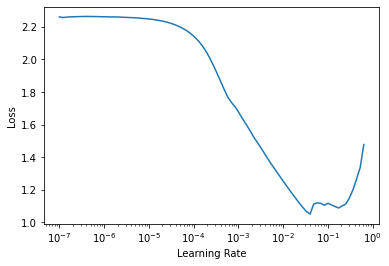

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,precision recall f1score,time
0,0.124379,0.038542,83.4262 82.9640 83.1944,01:39
1,0.021259,0.012871,93.0679 93.9058 93.4850,01:40
2,0.011386,0.008489,95.4545 95.9834 95.7182,01:35
3,0.007987,0.007626,96.0581 96.1911 96.1246,01:35
4,0.005611,0.007976,96.1353 96.4681 96.3014,01:36
5,0.004273,0.010448,96.6030 94.5291 95.5548,01:35
6,0.003218,0.008113,96.6137 96.8144 96.7139,01:35
7,0.002380,0.008328,97.1349 96.2604 96.6957,01:36
8,0.001769,0.008430,97.0629 96.1219 96.5901,01:35
9,0.001288,0.008511,97.1268 95.9834 96.5517,01:35


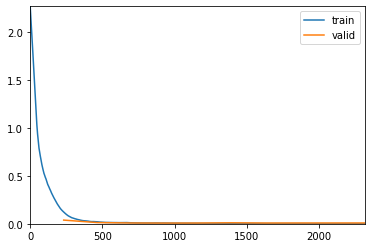

In [ ]:
learner.fit_one_cycle(10, 1e-3)

In [ ]:
learner.save('token_mean_hid256_stage_1')

Path('/content/drive/MyDrive/models/roberta_ner/models/token_mean_hid256_stage_1.pth')

### Stage 2: Unfreeze all and train entire model

In [37]:
learner.load('token_mean_hid256_stage_1')

In [ ]:
learner.unfreeze()

SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=9.12010818865383e-07)

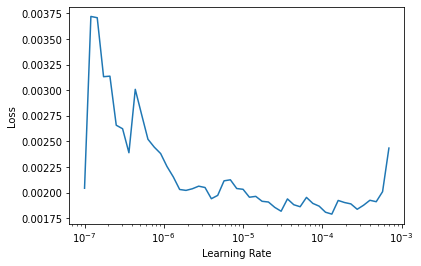

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,precision recall f1score,time
0,0.001590,0.008615,97.1950 95.9834 96.5854,01:58


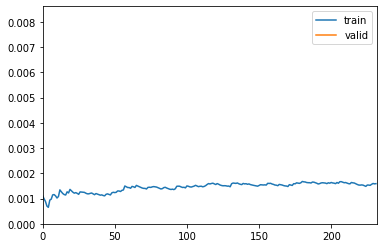

In [ ]:
lr = 1e-5
# learner.fit_one_cycle(5, slice(lr / (2.6 **4), lr))
learner.fit_one_cycle(1, slice(lr / (2.6 **4), lr))

In [ ]:
learner.save('token_mean_hid256_stage_2')

Path('/content/drive/MyDrive/models/roberta_ner/models/token_mean_hid256_stage_2.pth')

In [ ]:
# learner.export('roberta_ner_token_mean_hid256_9753_9743_9748.pkl', pickle_protocol=4)

## Evaluate model

### Create test dataloaders

In [44]:
learner.load('token_mean_hid256_stage_2')

In [39]:
test_dl = learner.dls.test_dl(test_data)

### Validate test_dl:
```
Precision: 97.0373
Recall:    97.2964
F1Score:   97.1667
```

In [40]:
learner.remove_cbs(ShowGraphCallback)

In [45]:
learner.validate(dl=test_dl)

(#2) [0.007782795466482639,'   97.0373     97.2964     97.1667']

### Get result file

In [46]:
test_pred = learner.metrics[0].y_pred

In [47]:
test_true = learner.metrics[0].y_true

In [48]:
y_pred = [learner.metrics[0].label_vocab[i] for i in test_pred]
y_true = [learner.metrics[0].label_vocab[i] for i in test_true]

In [49]:
with open('token_mean_hid512_result.txt', mode='w', encoding='utf8') as f:
    for t, p in zip(y_true, y_pred):
        f.write(f'w1\tw2\t{t}\t{p}\n')
        # f.write(f'{t}\t{p}\n')

In [ ]:
!bash conlleval.pl -l -r -d \\t < token_mean_hid512_result.txt

### Save result

In [ ]:
!mkdir drive/My\ Drive/models/bert_ner

In [ ]:
!cp -r models drive/My\ Drive/models/bert_ner

In [ ]:
!cp -r result.txt drive/My\ Drive/models/bert_ner

# Final result:
```
        & Precision &  Recall  & F$_{\beta=1} \\\hline
LOC     &   96.87\% &  98.62\% &  97.74 \\
MISC    &   97.73\% &  87.76\% &  92.47 \\
ORG     &   89.66\% &  85.40\% &  87.48 \\
PER     &   98.69\% &  98.76\% &  98.73 \\\hline
Overall &   97.04\% &  97.30\% &  97.17 \\\hline


        & Precision &  Recall  & F$_{\beta=1} \\\hline
B-LOC   &   97.42\% &  98.77\% &  98.09 \\
B-MISC  &  100.00\% &  87.76\% &  93.48 \\
B-ORG   &   94.19\% &  88.69\% &  91.35 \\
B-PER   &   98.84\% &  98.84\% &  98.84 \\
I-LOC   &   94.96\% &  97.62\% &  96.27 \\
I-MISC  &   97.73\% &  87.76\% &  92.47 \\
I-ORG   &   96.85\% &  92.95\% &  94.86 \\
I-PER   &   99.29\% &  99.59\% &  99.44 \\\hline
Overall &   97.74\% &  97.58\% &  97.66 \\\hline

```




# Training - Without pos chunk

## Config

In [59]:
config = Config(
    bs=64,
    config_path_or_pretrained_weights='vinai/phobert-base',
    model_path_or_pretrained_weights='vinai/phobert-base',
    custom_config={
        'output_hidden_states': True,
        'n_pos': 20,
        'n_chunk': 8,
    },
    n_tags=9,
    use_crf=True,
    token_reduction='mean',   # mean, concat, sum
    token2word_reduction='mean',    # mean, sum
    n_pos=20,
    n_chunk=8,
    use_pos_chunk=False,
    model_path=Path('/content/drive/MyDrive/models/roberta_ner'),
    data_path=Path('data/raw'),
    p_dropout=0.1,
    head_hidden_size=512,
)

## Data

### read data file

In [60]:
train_data = read_data(config.data_path/'train.txt')
valid_data = read_data(config.data_path/'dev.txt')
test_data = read_data(config.data_path/'test.txt')

### merge train and val -> split by range index

In [61]:
train_val_data = train_data + valid_data
train_len, val_len, train_val_len = len(train_data), len(valid_data), len(train_val_data)
splits = [list(range(train_len)), list(range(train_len, train_val_len))]

### datasets

In [62]:
tokenizer = PhobertTokenizer.from_pretrained(config.config_path_or_pretrained_weights)
w_tfms = [ItemGetter(0), WordTransformV2(tokenizer)]
pos_tfms = [ItemGetter(1), CategorizeList(pad='[pad_p]')]
chunk_tfms = [ItemGetter(2), CategorizeList(pad='[pad_c]')]
y_tfms = [ItemGetter(3), CategorizeList(pad='[pad_l]')]
ds = Datasets(
    train_val_data,
    tfms=[w_tfms, *([pos_tfms, chunk_tfms] if config.use_pos_chunk else []), y_tfms],
    splits=splits,
    n_inp=5 if config.use_pos_chunk else 3,
)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


### get dataloaders func

In [63]:
def get_dls(ds: Datasets, bs=64):
    dls = ds.dataloaders(
        bs=bs,
        before_batch=BeforeBatch(
            # pad_idxs=[w_tfms[-1].tokenizer.pad_token_id, pos_tfms[-1].pad_idx, chunk_tfms[-1].pad_idx, y_tfms[-1].pad_idx],
            pad_idxs=[
                w_tfms[-1].tokenizer.pad_token_id,
                *([pos_tfms[-1].pad_idx, chunk_tfms[-1].pad_idx] if config.use_pos_chunk else []), 
                -1,
            ],
            pad_fields=[0, 1, 2, 5] if config.use_pos_chunk else [0, 3],
            pad_firsts=[False] * 4 if config.use_pos_chunk else [False, False],
            use_pos_chunk=config.use_pos_chunk,
        ),
        n_inp=5 if config.use_pos_chunk else 3,
        verbose=True,
    )
    return dls

### dataloaders

In [64]:
dls = get_dls(ds, config.bs)

Setting up after_item: Pipeline: 
Setting up before_batch: Pipeline: BeforeBatch
Setting up after_batch: Pipeline: 


#### test one batch

In [65]:
for i in dls.one_batch():
    print(i.size())

torch.Size([64, 73])
(64,)
torch.Size([64, 65])
(64, 65)


## Create model

In [66]:
model = RobertaNER.from_pretrained(
    config_path_or_pretrained_weights=config.config_path_or_pretrained_weights,
    model_path_or_pretrained_weights=config.model_path_or_pretrained_weights,
    n_tags=config.n_tags,
    custom_config=config.custom_config,
    token_reduction=config.token_reduction,
    token2word_reduction=config.token2word_reduction,
    p_dropout=config.p_dropout,
    use_pos_chunk=config.use_pos_chunk,
    head_hidden_size=config.head_hidden_size,
)

## Get loss function

In [67]:
loss_func = model.get_loss_func()

## Create learner

In [68]:
learner = Learner(
    dls=dls,
    model=model,
    loss_func=loss_func,
    splitter=splitter,
    cbs=[ShowGraphCallback(),],
    metrics=[ConllevalMetric(label_vocab=y_tfms[-1].vocab),],
    path=config.model_path,
)

## Train model

### Stage 1: Freeze model and train only head

In [ ]:
learner.freeze()

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.0002754228771664202)

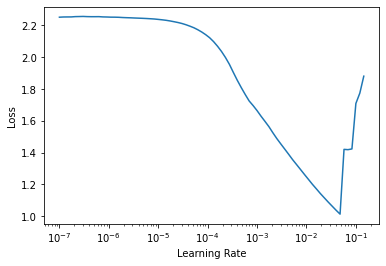

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,precision recall f1score,time
0,0.131910,0.042557,79.5165 81.9945 80.7364,01:25
1,0.029366,0.017452,91.4068 91.3435 91.3751,01:25
2,0.021926,0.017659,90.5686 93.7673 92.1402,01:25
3,0.015319,0.014309,93.1177 93.6981 93.4070,01:25
4,0.011995,0.012544,93.5306 94.1136 93.8212,01:26
5,0.008848,0.014444,95.1977 93.3518 94.2657,01:25
6,0.005971,0.014154,94.6779 93.6288 94.1504,01:25
7,0.005846,0.016527,94.4915 92.6593 93.5664,01:25
8,0.004232,0.015558,94.9474 93.6981 94.3186,01:24
9,0.004155,0.015924,95.1443 93.6288 94.3805,01:24


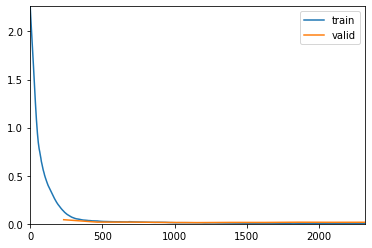

In [ ]:
learner.fit_one_cycle(10, 1e-3)

In [ ]:
learner.save('no_pc_stage1')

Path('/content/drive/MyDrive/models/roberta_ner/models/no_pc_stage1.pth')

In [ ]:
learner.loss_func = None
# learner.export('no_pc_stage1_model.pkl', pickle_protocol=4)

### Stage 2: Unfreeze and train all

In [ ]:
learner.load('no_pc_stage1')

In [ ]:
learner.unfreeze()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=2.75422871709452e-06)

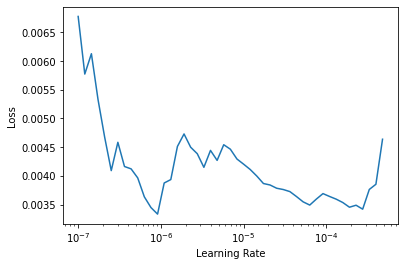

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,precision recall f1score,time
0,0.003811,0.015774,94.6704 93.4903 94.0767,01:48


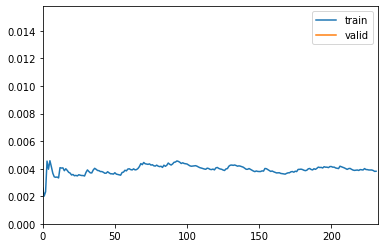

In [ ]:
lr = 1e-4
learner.fit_one_cycle(1, slice(lr / (2.6 ** 4), lr))

In [ ]:
learner.save('no_pc_stage2')

Path('/content/drive/MyDrive/models/roberta_ner/models/no_pc_stage2.pth')

## Evaluate model

### Create test dataloaders

In [69]:
test_dl = learner.dls.test_dl(test_data)

In [70]:
for i in test_dl.one_batch():
    print(i.size())

torch.Size([64, 57])
(64,)
torch.Size([64, 55])
(64, 55)


### Validate test_dl:
```
        & Precision &  Recall  & F$_{\beta=1} \\\hline
LOC     &   93.49\% &  94.78\% &  94.13 \\
MISC    &   93.18\% &  83.67\% &  88.17 \\
ORG     &   75.00\% &  72.26\% &  73.61 \\
PER     &   98.06\% &  97.45\% &  97.75 \\\hline
Overall &   93.82\% &  93.69\% &  93.75 \\\hline

        & Precision &  Recall  & F$_{\beta=1} \\\hline
B-LOC   &   94.24\% &  95.06\% &  94.65 \\
B-MISC  &   93.18\% &  83.67\% &  88.17 \\
B-ORG   &   84.46\% &  77.37\% &  80.76 \\
B-PER   &   99.07\% &  98.38\% &  98.72 \\
I-LOC   &   87.50\% &  92.22\% &  89.80 \\
I-MISC  &   97.62\% &  83.67\% &  90.11 \\
I-ORG   &   86.01\% &  85.14\% &  85.57 \\
I-PER   &   99.79\% &  97.97\% &  98.87 \\\hline
Overall &   94.79\% &  94.23\% &  94.51 \\\hline
```

In [71]:
learner.load('no_pc_stage1')

In [72]:
# stage 1
learner.remove_cbs(ShowGraphCallback)
learner.validate(dl=test_dl)

(#2) [0.018783556297421455,'   93.8168     93.6916     93.7542']

In [ ]:
# stage 2
learner.remove_cbs(ShowGraphCallback)
learner.validate(dl=test_dl)

(#2) [0.01866874471306801,'   93.7271     93.7583     93.7427']

### Get result file

In [73]:
test_pred = learner.metrics[0].y_pred

In [74]:
test_true = learner.metrics[0].y_true

In [75]:
y_pred = [learner.metrics[0].label_vocab[i] for i in test_pred]
y_true = [learner.metrics[0].label_vocab[i] for i in test_true]

In [ ]:
with open('token_mean_hid512_result_no_pc.txt', mode='w', encoding='utf8') as f:
    for t, p in zip(y_true, y_pred):
        f.write(f'w1\tw2\t{t}\t{p}\n')